![Sizing Lab](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/Baniere.png)

# TP1 - Case study specification

*Written by Marc Budinger, INSA Toulouse, France*

The objective of this notebook is to develop tools to:
- generate typical point-ot-point mission profiles to analyse the energetic performance of different mobility;
- optimize thoose given profiles shapes/strategy to minimize consumption;

In order to have flexibility in the definition of the case studies, an object-oriented programming approach will be used and links will be given to understand the formalism.

# Table of Contents
1. [Vehicles definition](#Vehicles-definition)
2. [Mission profile definition and consumption simulation](#Mission-profile-definition-and-consumption-simulation)
3. [Automatically find speed profile decomposition (k1, k2, k3) with an optimization process](#Automatically-find-speed-profile-decomposition-(k1,-k2,-k3)-with-an-optimization-process)
4. [Different vehicules energetic comparison](#Different-vehicules-energetic-comparison)
5. [Homework](#Homework)

## Vehicles definition

Different types of urban electric vehicles exist (tram, trolley bus, [electric bus](https://blog.hcigroupe.com/de-6-%C3%A0-24-m%C3%A8tres-tour-dhorizon-des-diff%C3%A9rentes-longueurs-de-bus)), we can define a general vehicle [class](https://www.w3schools.com/python/python_classes.asp) which can represent the multiple possible supports.

In [1]:
class vehicle:
    def __init__(self, MaxSpeed, MaxAcc, NumberPass, Weight, Crr, Cd, FrontArea):
        self.MaxSpeed = MaxSpeed # [m/s] maximal speed
        self.NumberPass = NumberPass # [-] passenger capacity (pass/veh)
        self.Weight = Weight # [kg] effective weight (with passenger: add 62kg/pass)
        self.Crr = Crr # [-] rolling resistance coefficient
        self.Cd = Cd # [-] drag coefficient
        self.FrontArea = FrontArea # [m²] frontal area
        self.update_acc(MaxAcc)
        
    def update_acc(self, MaxAcc):
        self.MaxAcc = MaxAcc # [m/s²] maximal acceleration
        self.Fmax = self.Weight*MaxAcc # [N] max traction force
        self.Pmax = self.Fmax*self.MaxSpeed # [W] max corner power


Here you will find some useful vehicle characteristics for the rest of the study.

| Attribute  | Tram      | Trolleybus      | Bus | Car (Tesla 3) |
|---    |:-:    |:-:    |:-:    |:-:    |
| Maximum operational speed     |  60 km/h     |  60 km/h     | 50 km/h | 100 km/h (1st gear) |
| Acceleration and braking      | 1.2 m/s²      |  1.2 m/s²     | 1.2 m/s² | 4.6 m/s² |
| Passenger capacity      | 220      | 138      | 95 | 4 |
| Vehicle effective weight @ 62 kg/p | 57049 kg | 27656 kg | 19500 kg |1800 kg  |
| Rolling resistance coefficient | 0.006 | 0.015 | 0.015 | 0.015 |
| Aerodynamic drag coefficient| 0.6 | 0.6 |0.6 | 0.23 | 
| Frontal area | 8.5 m² | 8.5 m² | 8.5 m²| 2.22 m² |



> **Exercise 1:** Define the 4 instances corresponding to the vehicles described in the above table.

In [2]:
Tram = vehicle(MaxSpeed=60*1e3/3600, MaxAcc=1.2, NumberPass=220, Weight=57049, Crr=0.006, Cd=0.6, FrontArea=8.5)
TrolleyBus = vehicle(60*1e3/3600, 1.2, 138, 27656, 0.015, 0.6, 8.5)
Bus = vehicle(50*1e3/3600, 1.2, 95, 19500, 0.015, 0.6, 8.5)
Car = vehicle(60*1e3/3600, 4.6, 4, 1800, 0.015, 0.23, 2.22)

## Mission profile definition and consumption simulation

The objective now is to simulate the dynamic evolution of the main mechanical quantities (position, speed, acceleration, traction/braking force, traction/braking power and cumulated energy) on typical sections of urban routes (a point-to-point scenario).

When a vehicle travels from point A (Starting point - v=0km/h) to point B (Stopping point - v=0km/h) it generally passes through four stages namely:
- Acceleration portion (traction force is considered constant);
- Maintained speed portion (or null acceleration);
- Coasting/freewheel portion: traction/braking force is null;
- Braking portion (braking force is considered constant).

The control points for switching from one portion to the other one are defined in the following code by using 3 ratio parameters $k_1, k_2, k_3$ as shown in the figure below: 

<center><img src="https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/GeneralspeedProfile.PNG" alt="General Speed Profile" /></center>


> **Exercise 2:** Try to find the shape of the acceleration=f(distance) and propulsive\braking-force=f(distance) curves.


<center><img src="https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/SimplifiedspeedProfile.PNG" alt="Simplified Speed Profile" /></center>
<center><img src="https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/SimplifiedsaccelerationProfile.PNG" alt="Simplified Acceleration Profile" /></center>

A code skeleton initial implementation is given to define a point-to-point dynamic simulation.
The idea is to propose a simple [Euler inegration](https://fr.wikipedia.org/wiki/R%C3%A9solution_num%C3%A9rique_des_%C3%A9quations_diff%C3%A9rentielles) of vehicle longitudinal dynamics and calculate associated data (power, energy) across the entire profile.

> **Exercise 3:** Based on available data, implement longitudinal dynamic differential equation (PFD) in CODE 2 section. What force/parameter evolution could be added to take into account variations in altitude?

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class SimulSection:
    
    def __init__(self, Vehicle, Distance, MeanSpeed, BrakeRatioMax, dt):
        
        # Parameters definition
        self.Vehicle = Vehicle # store vehicle class instance
        self.Distance = Distance # [m] A-B distance to travel
        self.MeanSpeed = MeanSpeed # [m/s] Mean Speed
        self.TravelTime = self.Distance / self.MeanSpeed  # [s] Travel time
        self.BrakeRatioMax = BrakeRatioMax # [-], <1 =F_braking/f_propulsion (to reproduce driver behavior)
        self.dt = dt # Time step for numerical solver

        # Constants
        self.rho = 1.25 # [kg/m3] air density
        self.g = 9.81 # [m/s²] gravity
        
        # Validate vehicle limits match specifications (print warning):
        #    - max acceleration/braking vs. Vmean and distance (triangular acceleration profile)
        #    - Vmean vs. max speed on trapezoidal profile
        ###############################################
        if (self.MeanSpeed>=Vehicle.MaxSpeed):
           print("[ERROR1] Profile mean speed is too high : exceed vehicle max speed!")
        self.update_acc(self.Vehicle.MaxAcc)
        ###############################################

    def update_acc(self, MaxAcc):
        self.Vehicle.update_acc(MaxAcc)
        # Validate vehicle limits match specifications (print warning):
        #    - max acceleration/braking vs. Vmean and distance (triangular acceleration profile)
        #    - Vmean vs. max speed on trapezoidal profile
        ###############################################
        if ((self.Distance/self.MeanSpeed)**2-4*self.Distance/self.Vehicle.MaxAcc)>=0:
            v_m = self.Vehicle.MaxAcc/2*(self.Distance/self.MeanSpeed-((self.Distance/self.MeanSpeed)**2-4*self.Distance/self.Vehicle.MaxAcc)**0.5)
            if (v_m>=self.Vehicle.MaxSpeed):
                print("[ERROR2] Profile mean speed is too high (Vm=" + str(round(36*v_m)/10) +"km/h) : exceed vehicle max speed!")
        if (self.Vehicle.MaxAcc < 2*self.MeanSpeed**2/self.Distance*(1+self.BrakeRatioMax)/self.BrakeRatioMax):
            print("[ERROR3] Vehicle acceleration is too low , should be >" + str(2*self.MeanSpeed**2/self.Distance*(1+self.BrakeRatioMax)/self.BrakeRatioMax) + "m/s²")
        ###############################################
            
    # local derivative of the vehicle state vector y (y=[x, dx/dt], x being the longitudinal position)
    def derivative(self, y, F):
        
        # state
        x, dxdt = y
        
        # Define derivative d²xdt²
        ###############################################
        dxdt2 = (F-(self.Vehicle.Crr*self.Vehicle.Weight*self.g
                    +1/2*self.rho*self.Vehicle.FrontArea*self.Vehicle.Cd*dxdt**2)*np.sign(dxdt))/self.Vehicle.Weight
        ###############################################
        
        dydt = [dxdt, dxdt2]
        return dydt 

  
    # https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html
    # solver numerique
        
    def solver(self, profile_ratios):
        
        # save profile ratios
        k1, k2, k3 = profile_ratios
        dt=self.dt # [s] integration time step

        # initialise vectors (time, position, speed, acceleration, power @ wheel, force @ wheel, energy @ wheel)
        self.tsection = [0]
        self.xsection = [0]
        self.vsection = [0]
        self.asection = [0] 
        self.psection = [0]
        self.Fsection = [0]
        self.NRJsection = [0]
        
        # while vehicle speed remains positive point B is not reached
        y= np.array([0, 0])
        while (y[1]>=0):
            
            # Depending on profile section/portion, define wheel force
            if (y[0]<k1*k2*k3*self.Distance):
                F=self.Vehicle.Fmax
            elif (y[0]<k3*k2*self.Distance):
                F=(self.Vehicle.Crr*self.Vehicle.Weight*self.g+1/2*self.rho*self.Vehicle.FrontArea*self.Vehicle.Cd*y[1]**2)*np.sign(y[1])
            elif (y[0]<k3*self.Distance):
                F=0
            else:
                F=-self.BrakeRatioMax*self.Vehicle.Fmax

            # Perform a simple Euler integration from t to t+dt
            dydt = self.derivative(y, F)
            y = y + dt*np.array(dydt)
                
            # Save vectors
            self.tsection = self.tsection + [self.tsection[-1]+dt]
            self.xsection = self.xsection + [y[0]]
            self.vsection = self.vsection + [y[1]]
            self.psection = self.psection + [y[1]*F]
            self.asection = self.asection + [dydt[1]] 
            self.Fsection = self.Fsection + [F] 
            self.NRJsection = self.NRJsection + [self.NRJsection[-1]+y[1]*F*dt]
            
    # Plot all the results vs. specification in graphs
    def plot(self):
        fig, axs = plt.subplots(3,2)
        
        axs[0,0].plot(self.tsection,self.xsection,'b-',label='Simulation')
        axs[0,0].plot(self.tsection,self.Distance*np.ones(len(self.tsection)),'g-',label='Specified distance')
        axs[0,0].set_ylabel("Position (m)")
        axs[0,0].set_xlabel('Time (s)')
        axs[0,0].legend()
        axs[0,0].grid()
        
        axs[1,0].plot(self.tsection, self.vsection,'b-', label='Simulation')
        axs[1,0].plot(self.tsection, self.MeanSpeed*np.ones(len(self.tsection)),'g-',label='Specified mean speed')
        axs[1,0].plot(self.tsection, np.mean(self.vsection)*np.ones(len(self.tsection)),'r--',label='Profile mean speed')
        axs[1,0].set_ylabel("Speed (m/s)")
        axs[1,0].set_xlabel('Time (s)')
        axs[1,0].legend()
        axs[1,0].grid()    
        
        axs[0,1].plot(self.tsection, self.Fsection,'b-')
        axs[0,1].set_ylabel("Force (N)")
        axs[0,1].set_xlabel('Time (s)')
        axs[0,1].grid()
        
        axs[2,0].plot(self.tsection, self.asection,'b-')
        axs[2,0].set_ylabel("Acceleration (m/s²)")
        axs[2,0].set_xlabel('Time (s)')
        axs[2,0].grid()
        
        axs[1,1].plot(self.tsection, np.array(self.psection)*1e-3,'b-')
        axs[1,1].set_ylabel("Power (kW)")
        axs[1,1].set_xlabel('Time (s)')
        axs[1,1].grid()
        
        axs[2,1].plot(self.tsection, np.array(self.NRJsection)*1e-3,'b-')
        axs[2,1].set_ylabel("Energy (kJ)")
        axs[2,1].set_xlabel('Time (s)') 
        axs[2,1].grid()
        
        fig.tight_layout()

    def ConsumptionPerPax(self,x):
        self.solver(x)
        print("Consumption per passenger: %.2f kJ/(Pax.km)"%(self.NRJsection[-1]/self.Vehicle.NumberPass/self.Distance))
        return (self.NRJsection[-1]/self.Vehicle.NumberPass/self.Distance)
    
    def MaxEnergyPoint(self,x):
        self.solver(x)
        print("Max energy discharge: %.0f kJ"%(max(self.NRJsection)*1e-3))
        return max(self.NRJsection)*1e-3

    def MaxPowerPoints(self,x):
        self.solver(x)
        print("Max power discharge: %.0f kW"%(max(self.psection)*1e-3))
        print("Max power recharge: %.0f kW"%(min(self.psection)*1e-3))
        return max(self.psection)*1e-3, min(self.psection)*1e-3
    


To check that the developed code does not containt errors, let us apply following Tram example:

Duration of traject for given mean speed: 92.77s
Consumption per passenger: 20.44 kJ/(Pax.km)
Max energy discharge: 4450 kJ
Max power discharge: 550 kW
Max power recharge: -464 kW


(550.4132429269536, -463.9859398041168)

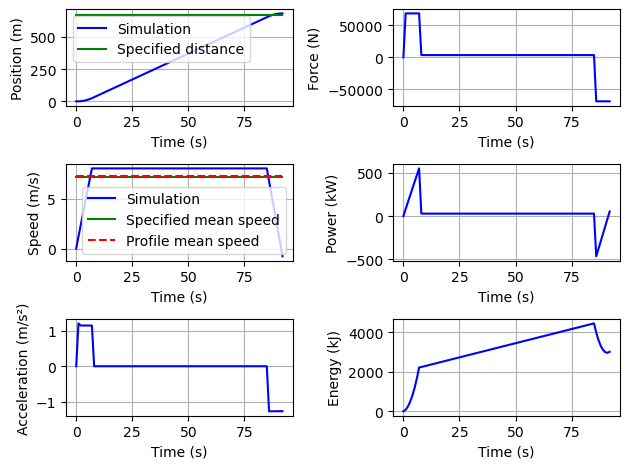

In [4]:
# Definition of the section under study
Travel_Tram = SimulSection(Vehicle=Tram, Distance=670, MeanSpeed=26*1e3/3600, BrakeRatioMax=1.0, dt=1.0)
print('Duration of traject for given mean speed: {:.2f}s'.format(670/(26*1e3/3600)))

# Profile integration, plotting and consummption per passenger evaluation
X=[0.036125972011676784, 1, 0.9638740279883232]
Travel_Tram.solver(X)
Travel_Tram.plot()
Travel_Tram.ConsumptionPerPax(X)
Travel_Tram.MaxEnergyPoint(X)
Travel_Tram.MaxPowerPoints(X)

When we look at the speed profile we can easily imagine two extrema cases :
 - a [triangular speed profile](https://fr.wikipedia.org/wiki/Loi_de_mouvement) (acceleration/deceleration, without constant speed & freewheel portion)
 - a [trapezoidal speed profile](https://fr.wikipedia.org/wiki/Loi_de_mouvement) (without freewheel portion)
They kind of relate to maximum performances achievable given the vehicle parameters.
The idea here is to compare the profile defined by user (average speed/distance, maximum brake decceleration) to extreme vehicle performances to see if it is feasible (i.e. a [k1, k2, k3] can be found).

> **Exercise 4:** Give the relationship between acceleration, braking ratio, average speed and distance traveled for triangular speed profile (k1=k2=1) if we assume the acceleration and braking phases are perfectly linear (i.e. resistive force negligible)! Start first to link k3 to braking ratio

We have the following equations (k beeing the braking ratio <1) to write k3, where t1 is the time relative to acceleration phase and t2 do decceleration:

$a . t_1=V_m$ and $k . a . t_2 = V_m$

$k_3 . D= \frac{V_m . t_2}{2}$ and $(1-k_3) . D= \frac{V_m . t_2}{2}$

So, $k_3=\frac{k}{1+k}$

Concerning the acceleration, we have:

$V_{aver}=\frac{V_m}{2} \implies V_m=2 . V_{aver}$

$V_{aver}.(t_1+t_2)=V_{aver}.(\frac{V_m}{a}+\frac{V_m}{k . a})=D \implies a=\frac{2 . V_{aver}^2}{D} . \frac{1+k}{k} < a_{max}$

For a braking ratio equal to 1 (k=1.0), the acceleration is given by:

$a=\frac{4 . V_{aver}^2}{D}  < a_{max}$

> **Exercise 5:** Give the relationship between k1 and k3 (k2=1) if we assume the acceleration and braking phases are perfectly linear (the resistive force is neglected) and equal (braking ratio =1 to simplify). Find then the relationship between max speed, average speed, ditance and acceleration. Then highligh the link between k3, max speed, acceleration and distance. 

We have three zones: t1 acceleration, t2 constant speed and t3 decceleration. We also know that k2=1 and:

$t_1 = t_3 = \frac{V_m}{a}$ and $k_1 . k_3 . D = (1-k_3) .D \implies k_1=\frac{1-k_3}{k_3}$

If we adapt the crossed distance quation, we have:

$2. t_1 . \frac{V_m}{2} + t_2 . V_m =D$ and $(2.t_1+t_2)=\frac{D}{V_{aver}}$

Isolating t2 from the right equation and injecting it to the left equation, we find:

$\frac{D.V_m}{V_{aver}}-t_1.V_m=D$

If we replace t1 expression we get a polynomial resolution of the max speed Vm:

$\frac{1}{a}.V_m^2-\frac{D}{V_{aver}}.V_m+D=0$

The root solutions are then (the '-' beeing the one):

$V_m=\frac{a}{2}.(\frac{D}{V_{aver}} \pm \sqrt{(\frac{D}{V_{aver}})^2-\frac{4.D}{a}})$

> **Exercise 6:** Complete CODE 1 section with checks and warnings based on exercice 4 calculations (compare also max speed to vehicle max speed). Check warning using following low acceleration tram instance.

In [5]:
import copy

# Test of lower acceleration
Travel_Tram_low_acc = copy.deepcopy(Travel_Tram)
Travel_Tram_low_acc.update_acc(0.3)
print("")

# Test of lower max speed
Travel_Tram_low_acc.Vehicle.MaxSpeed = 30*1e3/3600
Travel_Tram_low_acc.update_acc(0.5)

[ERROR3] Vehicle acceleration is too low , should be >0.3114059332964806m/s²

[ERROR2] Profile mean speed is too high (Vm=32.2km/h) : exceed vehicle max speed!


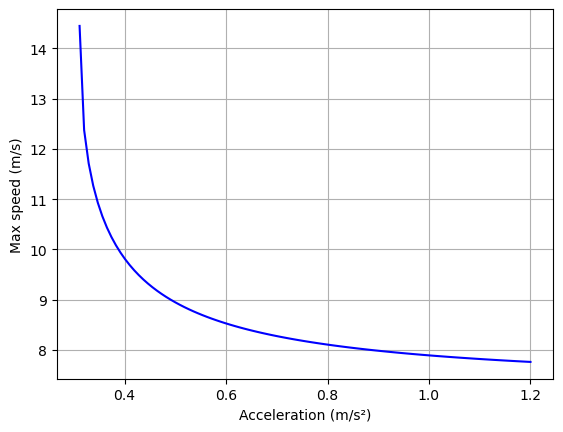

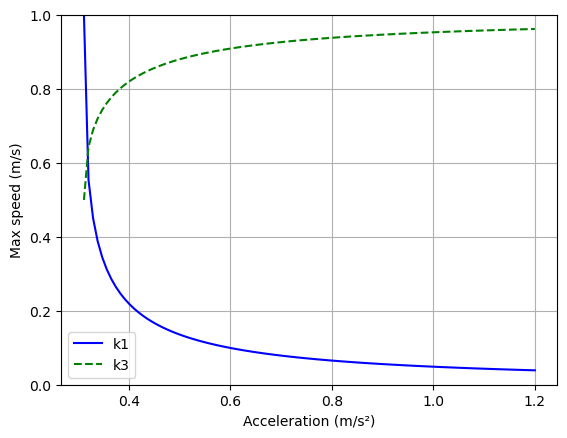

In [6]:
# Evalutation of maximum speed and k1/k3 coefficients
from scipy.optimize import root

a=np.linspace(4*Travel_Tram.MeanSpeed**2/Travel_Tram.Distance, Tram.MaxAcc, 100)

vmax = a/2*(Travel_Tram.Distance/Travel_Tram.MeanSpeed-((Travel_Tram.Distance/Travel_Tram.MeanSpeed)**2-4*Travel_Tram.Distance/a)**0.5)
plt.plot(a,vmax,'b-')
plt.xlabel('Acceleration (m/s²)')
plt.ylabel('Max speed (m/s)')
plt.grid()
plt.show()

k3 = 1-vmax**2/(2*a*Travel_Tram.Distance)
k1 = (1-k3)/k3
plt.plot(a,k1,'b-',label='k1')
plt.plot(a,k3,'g--',label='k3')
plt.xlabel('Acceleration (m/s²)')
plt.ylabel('Max speed (m/s)')
plt.grid()
plt.legend()
plt.ylim([0, 1])
plt.show()

> **Exercise 7:** Let us evaluate the Tram performance for different maximum accelerations a=[0.5, 0.8, 1.1] to see a trend on energy demand. As whe did not put any efficiency and by comparing the different resistive forces (Crr=0.006/10, so lowered to a factor 10) can this result be explained?

Max energy discharge: 4158 kJ
Max energy discharge: 4009 kJ
Max energy discharge: 3995 kJ


3994.9867315704114

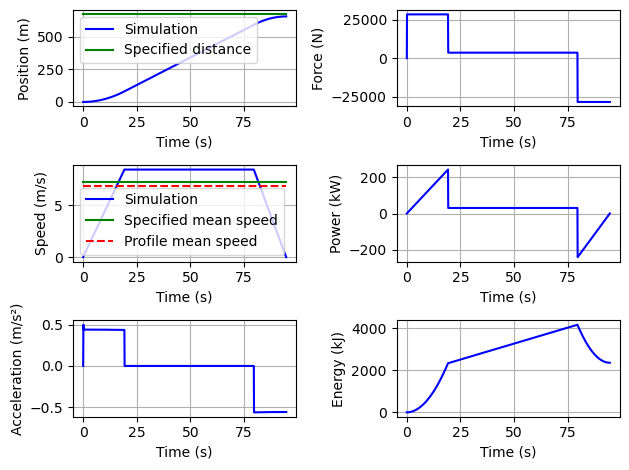

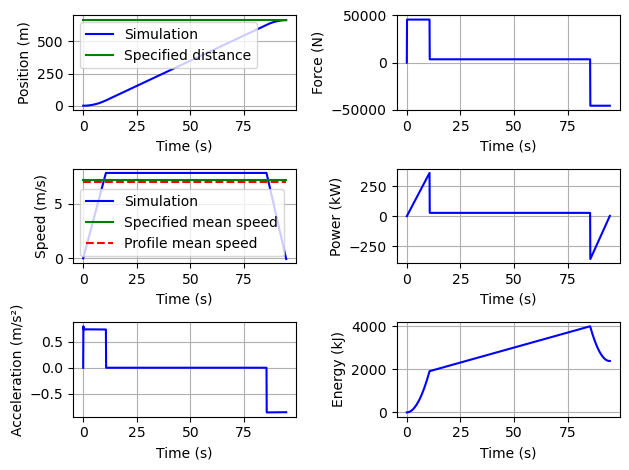

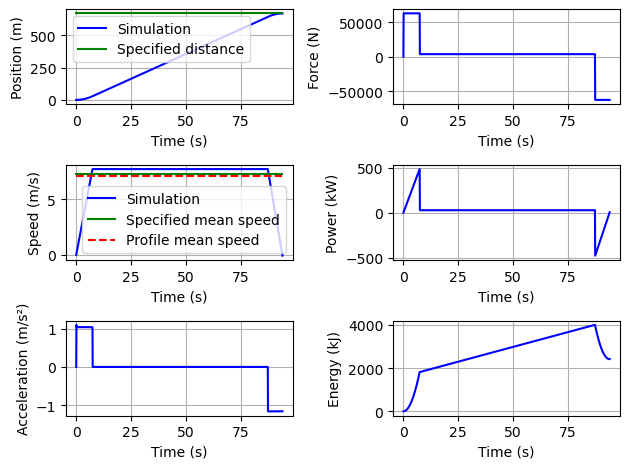

In [7]:
from numpy import interp

Travel_Tram.BrakeRatioMax=1.0
Travel_Tram.dt=0.1

# Treat 0.5m/s² acceleration
k1_value = interp(0.5, a, k1)
k3_value = interp(0.5, a, k3)
Travel_Tram.update_acc(0.5)
X = [k1_value, 1, k3_value]
Travel_Tram.solver(X)
Travel_Tram.plot()
Travel_Tram.MaxEnergyPoint(X)

# Treat 0.8m/s² acceleration
k1_value = interp(0.8, a, k1)
k3_value = interp(0.8, a, k3)
Travel_Tram.update_acc(0.8)
X = [k1_value, 1, k3_value]
Travel_Tram.solver(X)
Travel_Tram.plot()
Travel_Tram.MaxEnergyPoint(X)

# Treat 1.1m/s² acceleration
k1_value = interp(1.1, a, k1)
k3_value = interp(1.1, a, k3)
Travel_Tram.update_acc(1.1)
X = [k1_value, 1, k3_value]
Travel_Tram.solver(X)
Travel_Tram.plot()
Travel_Tram.MaxEnergyPoint(X)

## Automatically find speed profile decomposition (k1, k2, k3) with an optimization process

In a more general case and contrary to the previous hypothesis, the braking decceleration is not necessarily egual in magnitude to the acceleration, especially when doing regenerative braking (maximum power limited by energy storage). The following paper shows that it is possible to optimize the consumption of a tram by optimizing its profile:
> Tian, Z., Zhao, N., Hillmansen, S., Roberts, C., Dowens, T., & Kerr, C. (2019). SmartDrive: Traction energy optimization and applications in rail systems. IEEE Transactions on Intelligent Transportation Systems, 20(7), 2764-2773.

The previous class is extended to allow optimizing the parameters defining the profile shape $k_1, k_2, k_3$ with respect to different objectives: energy consumption (considering regenerative power) and max energy discharge. Only the first objective is given.

> **Exercise 8:** Write the gradient optimization for max energy discharge objective (modify directely the code and use arguments of objectifConco method).

In [8]:
from scipy.optimize import fmin_slsqp, differential_evolution
import numpy

class OptimSection(SimulSection):
    
    # Define objective to optimize: here normalized (divided by rolling resistance equivalent work) total consummed energy (including regenerative power)
    def objectifConso(self, x, *args):
        self.solver(x)
        NRJmin = self.xsection[-1]*self.Vehicle.Weight*self.g*self.Vehicle.Crr
        if args[0]:
            pen=numpy.sum(-1e2*numpy.array(self.contraintes(x)))
            pen=pen*(pen>0)
        else:
            pen=0.0
        return ((self.NRJsection[-1]*(args[2]==1)+max(self.NRJsection)*(args[2]==2))/NRJmin+pen)   
        
    # Define constraints to verify: traveled distance, traveled time (similar to average speed)
    def contraintes(self, x, *args):
        self.solver(x)
        TimeTravel = self.Distance / self.MeanSpeed  
        return [(self.xsection[-1]-self.Distance)/self.Distance, (TimeTravel-self.tsection[-1])/TimeTravel]    

    # SLSQP gradient optimization with constraints
    def optimizeConso_gradient(self, x0):
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,.99)]
        Xopt=fmin_slsqp(func=self.objectifConso, x0=x0, f_ieqcons = self.contraintes, bounds=Xbound, args=[False, 'gradient', 1], epsilon=1e-2)      
        return Xopt
    
    # Differential evolution optimization    
    def optimizeConso_genetic(self, x0):
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,0.99)]
        res=differential_evolution(func=self.objectifConso, x0=x0, args=[True, 'genetic', 1], bounds=Xbound)
        print(res)
        return res.x

     # SLSQP gradient optimization with constraints [MAX ENERGY]
    def optimizeConso2_gradient(self, x0):
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,.99)]
        Xopt=fmin_slsqp(func=self.objectifConso, x0=x0, f_ieqcons = self.contraintes, bounds=Xbound, args=[False, 'gradient', 2], epsilon=1e-2)      
        return Xopt
    

The usage of the class is quite simular that the previous one, but it adds an `optimizeConso` method which enables us to find the $k_1, k_2, k_3$ set. Let us apply it to the tram travel. 

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1.2338137148050947
            Iterations: 48
            Function evaluations: 597
            Gradient evaluations: 44
Optimal vector : [0.05122318 0.667643   0.95289809]
Constraints vector : [-0.01763549366395749, -0.08872305140961852]
Consumption per passenger: 18.50 kJ/(Pax.km)
Max energy discharge: 3306 kJ


3305.561486896886

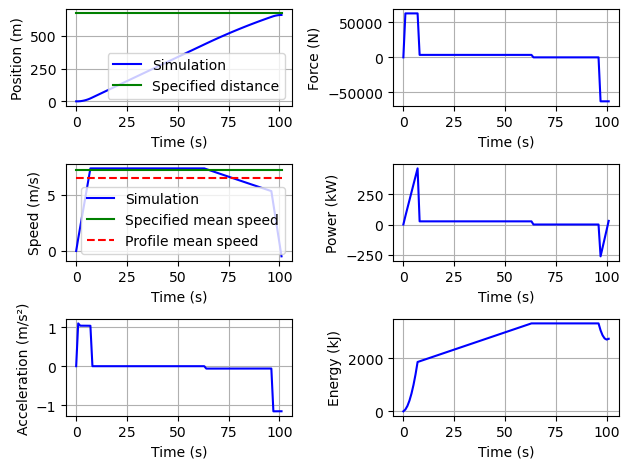

In [9]:
# Definition of the section under study
Travel_optim = OptimSection(Vehicle=Tram, Distance=670, MeanSpeed=26*1e3/3600, BrakeRatioMax=1.0, dt=1.0)

# Initial variables vector
X_init=[0.05, 0.6, 0.98]

# Optimization of the consumption with gradient
Xopt1=Travel_optim.optimizeConso_gradient(X_init)
print("Optimal vector :", Xopt1)
print("Constraints vector :", Travel_optim.contraintes(Xopt1))

Travel_optim.solver(Xopt1)
Travel_optim.plot()
Travel_optim.ConsumptionPerPax(Xopt1)
Travel_optim.MaxEnergyPoint(Xopt1)

             message: Optimization terminated successfully.
             success: True
                 fun: 1.2674860194871171
                   x: [ 5.618e-02  7.288e-01  9.872e-01]
                 nit: 17
                nfev: 814
          population: [[ 5.618e-02  7.288e-01  9.872e-01]
                       [ 4.981e-02  7.286e-01  9.791e-01]
                       ...
                       [ 5.645e-02  7.175e-01  9.867e-01]
                       [ 6.257e-02  6.756e-01  9.319e-01]]
 population_energies: [ 1.267e+00  1.270e+00 ...  1.268e+00  1.280e+00]
Optimal vector : [0.05618228 0.72880583 0.98718023]
Constraints vector : [0.03229873044764553, 0.008291873963515802]
Consumption per passenger: 19.97 kJ/(Pax.km)
Max energy discharge: 4031 kJ


4030.9930141354016

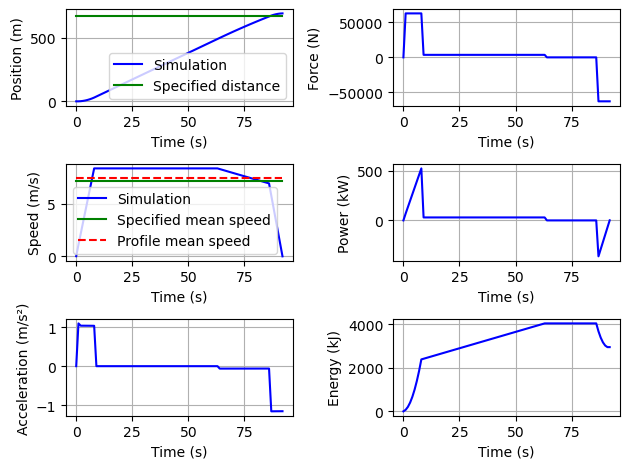

In [10]:
# Optimization of the consumption with genetic algorithm
X_init=[0.3, 1.0, 0.95]
Xopt1=Travel_optim.optimizeConso_genetic(X_init)
print("Optimal vector :", Xopt1)
print("Constraints vector :", Travel_optim.contraintes(Xopt1))

Travel_optim.solver(Xopt1)
Travel_optim.plot()
Travel_optim.ConsumptionPerPax(Xopt1)
Travel_optim.MaxEnergyPoint(Xopt1)

> **Exercise 9:** Compare the result to a 3 segments profile (acceleration, constant speed, decceleration). Evaluate the impact of the variation of the braking ratio for exemple [1.1, 0.77, 0.54].

             message: Optimization terminated successfully.
             success: True
                 fun: 1.2367359878503903
                   x: [ 5.549e-02  6.292e-01  9.870e-01]
                 nit: 27
                nfev: 1264
          population: [[ 5.549e-02  6.292e-01  9.870e-01]
                       [ 5.145e-02  6.837e-01  9.803e-01]
                       ...
                       [ 5.507e-02  6.930e-01  9.779e-01]
                       [ 6.115e-02  6.890e-01  9.398e-01]]
 population_energies: [ 1.237e+00  1.252e+00 ...  1.252e+00  1.259e+00]
Optimal vector : [0.05549458 0.62918976 0.98697908]
Constraints vector : [0.03335096221756688, -0.02404643449419564]
Consumption per passenger: 19.51 kJ/(Pax.km)
Max energy discharge: 3791 kJ


3790.894899714023

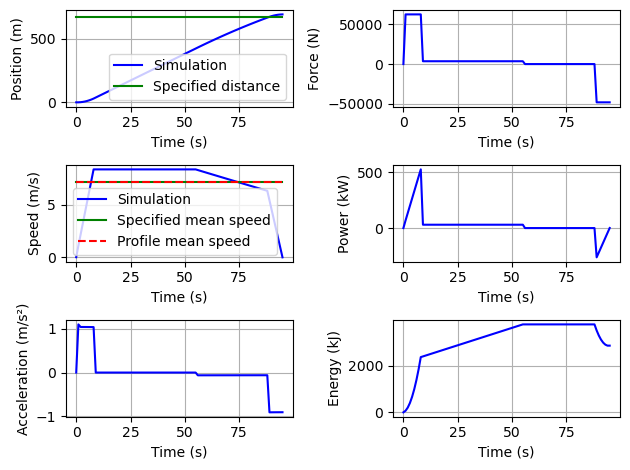

In [11]:
# Optimization of the consumption with gradient k=0.77
Travel_optim.BrakeRatioMax=0.77
Xopt2=Travel_optim.optimizeConso_genetic(X_init)
print("Optimal vector :", Xopt2)
print("Constraints vector :", Travel_optim.contraintes(Xopt2))
Travel_optim.solver(Xopt2)
Travel_optim.plot()
Travel_optim.ConsumptionPerPax(Xopt2)
Travel_optim.MaxEnergyPoint(Xopt2)

             message: Optimization terminated successfully.
             success: True
                 fun: 1.2213025282952445
                   x: [ 5.444e-02  7.469e-01  9.896e-01]
                 nit: 23
                nfev: 1084
          population: [[ 5.444e-02  7.469e-01  9.896e-01]
                       [ 5.407e-02  7.507e-01  9.822e-01]
                       ...
                       [ 5.442e-02  8.054e-01  9.769e-01]
                       [ 5.379e-02  7.524e-01  9.694e-01]]
 population_energies: [ 1.221e+00  1.223e+00 ...  1.230e+00  1.225e+00]
Optimal vector : [0.05444466 0.74689974 0.98960099]
Constraints vector : [0.05947497290440903, -0.0456053067993366]
Consumption per passenger: 19.75 kJ/(Pax.km)
Max energy discharge: 4061 kJ


4061.005278438074

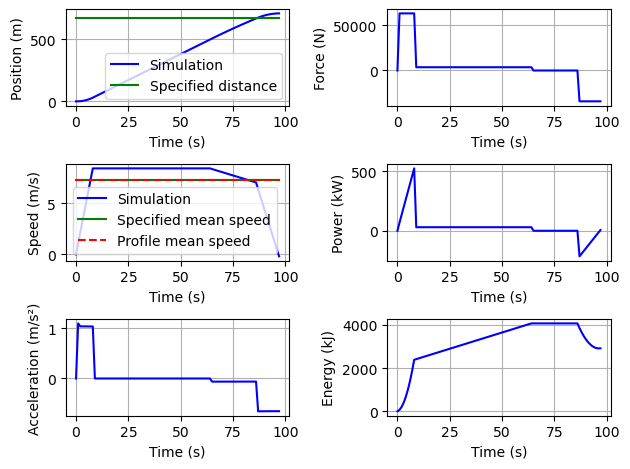

In [12]:
# Optimization of the consumption with gradient k=0.54
Travel_optim.BrakeRatioMax=0.54
Xopt3=Travel_optim.optimizeConso_genetic(X_init)
print("Optimal vector :", Xopt3)
print("Constraints vector :", Travel_optim.contraintes(Xopt3))
Travel_optim.solver(Xopt3)
Travel_optim.plot()
Travel_optim.ConsumptionPerPax(Xopt3)
Travel_optim.MaxEnergyPoint(Xopt3)

## Different vehicules energetic comparison

> **Exercise 10:** For the same travel (distance, mean speed) compare the consumption of different vehicles (tramway, tram, bus, car). The function `ConsumptionPerPax` return and print the consumption per km and per passenger. Compare the results with this [publication](https://reporterre.net/Taxis-volants-aux-JO-un-avis-defavorable-sur-le-projet). 

Tramway :
             message: Optimization terminated successfully.
             success: True
                 fun: 1.2293129555100613
                   x: [ 1.512e-01  3.523e-01  9.860e-01]
                 nit: 15
                nfev: 724
          population: [[ 1.512e-01  3.523e-01  9.860e-01]
                       [ 1.283e-01  4.459e-01  9.491e-01]
                       ...
                       [ 1.521e-01  3.711e-01  9.892e-01]
                       [ 1.708e-01  3.290e-01  9.602e-01]]
 population_energies: [ 1.229e+00  1.250e+00 ...  1.238e+00  1.233e+00]
Optimal vector : [0.15120416 0.35231742 0.98602701]
Constraints vector : [0.039242456029486124, -0.03482587064676612]
Consumption per passenger: 19.55 kJ/(Pax.km)
----


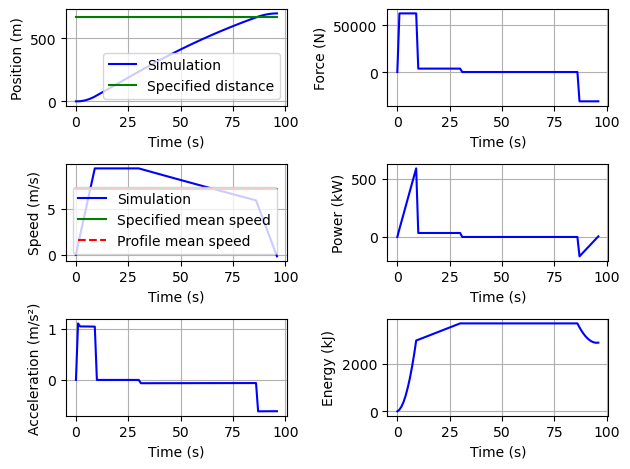

In [13]:
print("Tramway :")
Trajet = OptimSection(Tram, 670, 26*1e3/3600, 0.5, 1.0)
X=[0.3, 1.0, 0.95]
Xopt4=Trajet.optimizeConso_genetic(X)
print("Optimal vector :", Xopt4)
print("Constraints vector :", Travel_optim.contraintes(Xopt4))
Trajet.solver(Xopt4)
Trajet.plot()
Trajet.ConsumptionPerPax(Xopt4)
print("----")

Trolleybus :
             message: Optimization terminated successfully.
             success: True
                 fun: 1.0827879933523217
                   x: [ 5.487e-02  7.758e-01  9.891e-01]
                 nit: 19
                nfev: 904
          population: [[ 5.487e-02  7.758e-01  9.891e-01]
                       [ 7.774e-02  6.674e-01  9.781e-01]
                       ...
                       [ 6.191e-02  7.799e-01  9.647e-01]
                       [ 7.332e-02  7.362e-01  9.854e-01]]
 population_energies: [ 1.083e+00  1.086e+00 ...  1.084e+00  1.090e+00]
Optimal vector : [0.05487388 0.77577932 0.98911166]
Constraints vector : [0.055577545125031554, -0.0456053067993366]
Consumption per passenger: 32.51 kJ/(Pax.km)
----


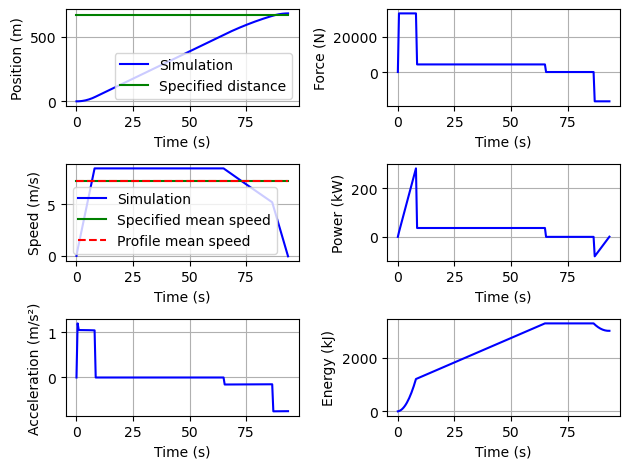

In [14]:
print("Trolleybus :")
Trajet = OptimSection(TrolleyBus, 670, 26*1e3/3600, 0.5, 0.5)
X=[0.3, 1.0, 0.95]
Xopt5=Trajet.optimizeConso_genetic(X)
print("Optimal vector :", Xopt5)
print("Constraints vector :", Travel_optim.contraintes(Xopt5))
Trajet.solver(Xopt5)
Trajet.plot()
Trajet.ConsumptionPerPax(Xopt5)
print("----")

Bus :
             message: Optimization terminated successfully.
             success: True
                 fun: 1.104685791607665
                   x: [ 6.248e-02  7.689e-01  9.419e-01]
                 nit: 13
                nfev: 634
          population: [[ 6.248e-02  7.689e-01  9.419e-01]
                       [ 6.527e-02  8.750e-01  9.035e-01]
                       ...
                       [ 6.305e-02  7.764e-01  9.272e-01]
                       [ 5.728e-02  8.992e-01  9.159e-01]]
 population_energies: [ 1.105e+00  1.123e+00 ...  1.106e+00  1.112e+00]
Optimal vector : [0.06248006 0.76892049 0.94188774]
Constraints vector : [0.03151373701334247, 0.07296849087893868]
Consumption per passenger: 32.52 kJ/(Pax.km)
----


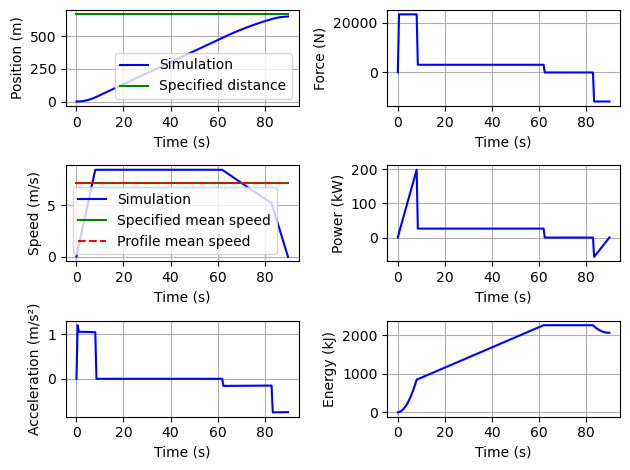

In [15]:
print("Bus :")
Trajet = OptimSection(Bus, 670, 26*1e3/3600, 0.5, 0.5)
Xopt6=Trajet.optimizeConso_genetic(X)
Trajet.solver(Xopt6)
print("Optimal vector :", Xopt6)
print("Constraints vector :", Travel_optim.contraintes(Xopt6))
Trajet.plot()
Trajet.ConsumptionPerPax(Xopt6)
print("----")

Car :
             message: Optimization terminated successfully.
             success: True
                 fun: 1.208350996802271
                   x: [ 1.142e-02  6.605e-01  9.881e-01]
                 nit: 17
                nfev: 814
          population: [[ 1.142e-02  6.605e-01  9.881e-01]
                       [ 1.423e-02  7.064e-01  9.842e-01]
                       ...
                       [ 1.359e-02  6.617e-01  9.726e-01]
                       [ 1.089e-02  6.530e-01  9.360e-01]]
 population_energies: [ 1.208e+00  1.219e+00 ...  1.210e+00  1.215e+00]
Optimal vector : [0.01141635 0.66052566 0.98811948]
Constraints vector : [-0.11398580157464912, -0.929519071310116]
Consumption per passenger: 79.47 kJ/(Pax.km)
----


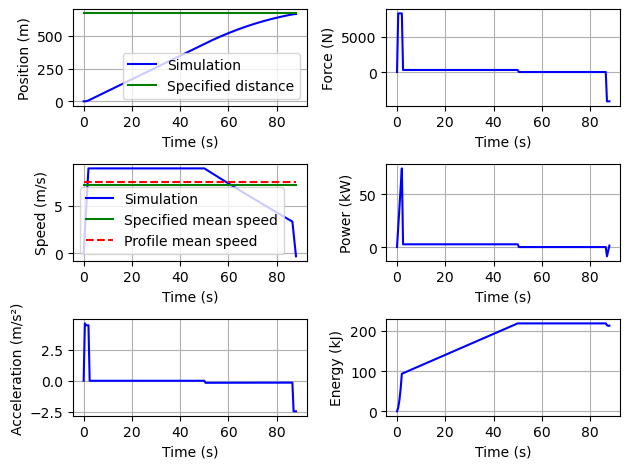

In [16]:
print("Car :")
Trajet = OptimSection(Car, 670, 26*1e3/3600, 0.5, 0.5)
Xopt7=Trajet.optimizeConso_genetic(X)
Trajet.solver(Xopt7)
print("Optimal vector :", Xopt7)
print("Constraints vector :", Travel_optim.contraintes(Xopt7))
Trajet.plot()
Trajet.ConsumptionPerPax(Xopt7)
print("----")

## Homework

Read the following paper before next session to understand how hybridation analysis can be implemented at profile level:
> Jaafar, A., Sareni, B., Roboam, X., & Thiounn-Guermeur, M. (2010, September). Sizing of a hybrid locomotive based on accumulators and ultracapacitors. In 2010 IEEE Vehicle Power and Propulsion Conference (pp. 1-6). IEEE. [[pdf](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/papers/Sizing_of_a_hybrid_locomotive_based_on_accumulators_and_ultracapacitors.pdf)]